In [1]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys

sys.path.append("../")

from src.common_functions import *

In [2]:
# sample data
# RAW_DATA_PATH1 = "../datasets/fraud/fraudTrain.csv"
# RAW_DATA_PATH2 = "../datasets/fraud/fraudTest.csv"
SAMPLED_DATA_PATH = "../datasets/fraud/cc_fraud_2.csv"
DATASET_NAME = Path(SAMPLED_DATA_PATH).stem
# raw_data1 = pd.read_csv("../datasets/fraud/fraudTrain.csv", index_col='Unnamed: 0')
# raw_data2 = pd.read_csv("../datasets/fraud/fraudTest.csv", index_col='Unnamed: 0')
# raw_data = pd.concat([raw_data1, raw_data2])
# raw_data = raw_data.rename(columns=dict(zip(raw_data.columns, list(map(to_snake_case, raw_data.columns)))))
# raw_data.head()
# _to_drop, df = train_test_split(raw_data, test_size=0.055, random_state=42, stratify=raw_data["is_fraud"])
# df.to_csv(SAMPLED_DATA_PATH, header=True, sep=",")
# del _to_drop
df = pd.read_csv(SAMPLED_DATA_PATH, index_col='Unnamed: 0')
print(df.shape[0])
df["is_fraud"].value_counts()/df.shape[0]*100

101882


is_fraud
0    99.478809
1     0.521191
Name: count, dtype: float64

In [3]:
df.isna().any()

trans_date_trans_time    False
cc_num                   False
merchant                 False
category                 False
amt                      False
first                    False
last                     False
gender                   False
street                   False
city                     False
state                    False
zip                      False
lat                      False
long                     False
city_pop                 False
job                      False
dob                      False
trans_num                False
unix_time                False
merch_lat                False
merch_long               False
is_fraud                 False
dtype: bool

In [4]:
numerical_columns = df.select_dtypes(
        include='number').columns.to_list()
numerical_columns

['cc_num',
 'amt',
 'zip',
 'lat',
 'long',
 'city_pop',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

In [5]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
81955,2019-02-18 05:13:53,30442439074871,fraud_Prohaska-Murray,gas_transport,84.50,Linda,Sanchez,F,6574 William Hill Apt. 375,Jermyn,...,41.5744,-75.5881,6508,Training and development officer,1981-06-22,e87d0600784494b1fa22cc39ee43a664,1329542033,41.415102,-74.742120,0
105389,2020-07-27 21:39:15,4599735407877245080,fraud_Crona and Sons,kids_pets,141.70,Mary,Myers,F,39787 Pamela Fall Suite 639,Tiptonville,...,36.3846,-89.4649,5577,Geochemist,1964-12-30,aa521d71ed29b262ed53702992785426,1374961155,35.532554,-89.097033,0
442525,2020-12-07 04:50:50,375848982312810,fraud_Erdman-Kertzmann,gas_transport,92.17,Dale,Smith,M,25036 Contreras Turnpike Suite 270,Purmela,...,31.4841,-97.9903,258,Web designer,1943-12-15,ebdbe410178c5365013842e9555aac59,1386391850,30.521008,-97.837087,0
916621,2019-12-30 03:31:10,375237305371366,fraud_Sawayn PLC,shopping_pos,9.89,David,Erickson,M,616 Jimenez Meadow Apt. 701,East Rochester,...,43.1128,-77.4906,8019,Retail buyer,1928-06-26,ff86e07988b326802e76ef0db08dc994,1356838270,42.571261,-78.185175,0
117618,2019-03-07 18:03:51,4607072969078276,fraud_Abbott-Steuber,personal_care,13.98,Brenda,Perez,F,033 Tara Brook Suite 523,Coyle,...,35.8985,-97.2607,1493,Amenity horticulturist,1985-03-21,bff6baa0a339d57d105bd587012d35a9,1331143431,36.858453,-97.334306,0


In [6]:
df.dtypes

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [7]:
import numpy as np

def preprocess_lat_lon(df:pd.DataFrame, lat_col_name:str="latitude", lon_col_name:str="longitude") -> pd.DataFrame:
    """
    Preprocesses latitude and longitude columns.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to preprocess.
    lat_col_name : str
        The name of the latitude column.
    lon_col_name : str
        The name of the longitude column.
        
    Returns
    -------
    pd.DataFrame
        The preprocessed dataframe.
    """
    # Convert to radians
    df[f"{lat_col_name}_x"] = np.cos(df[lat_col_name]) * np.cos(df[lon_col_name])
    df[f"{lon_col_name}_y"] = np.cos(df[lat_col_name]) * np.sin(df[lon_col_name])
    df[f"{lat_col_name}_z"] = np.sin(df[lat_col_name])
    return df.drop([lat_col_name, lon_col_name], axis=1)

In [10]:
y = "is_fraud"

# some generic cleaning

# otherwise unrecognized cases in test set
counts = df.value_counts([y, "job"])
jobs_to_filter = counts[counts==1].reset_index()["job"].unique()
df = df.loc[~df.job.isin(jobs_to_filter)]

COLUMNS_TO_DROP = ["city", "trans_date_trans_time", "merchant", "first", "last", "street", "zip", "trans_num", "dob"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

raw_features = raw_features.transform(preprocess_lat_lon, lat_col_name="lat", lon_col_name="long")
raw_features = raw_features.transform(preprocess_lat_lon, lat_col_name="merch_lat", lon_col_name="merch_long")

# ML tuning
train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[[y, "job"]])

fit_le = LabelEncoder().fit(train[y])

In [11]:
pipeline = build_sklearn_pipeline(train, y, "logistic", LogisticRegression())
pipeline.fit(train.drop(y, axis=1), train[y])
print(Pipeline(pipeline.steps[:-1]).transform(train.drop(y, axis=1)).shape)
pipeline.predict(train.drop(y, axis=1))

(54081, 384)


array([0, 0, 0, ..., 0, 1, 1])

In [13]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [10, 20,30],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV 2/5] END logistic__C=1, logistic__penalty=l2, over__sampling_strategy=0.2, pca__n_components=10, under__sampling_strategy=0.2;, score=nan total time=   0.8s
[CV 3/5] END logistic__C=1, logistic__penalty=l2, over__sampling_strategy=0.2, pca__n_components=10, under__sampling_strategy=0.2;, score=nan total time=   0.8s
[CV 1/5] END logistic__C=1, logistic__penalty=l2, over__sampling_strategy=0.2, pca__n_components=10, under__sampling_strategy=0.2;, score=nan total time=   0.8s
[CV 2/5] END logistic__C=1, logistic__penalty=l2, over__sampling_strategy=0.2, pca__n_components=10, under__sampling_strategy=0.1;, score=0.869 total time=   1.3s
[CV 1/5] END logistic__C=1, logistic__penalty=l2, over__sampling_strategy=0.2, pca__n_components=10, under__sampling_strategy=0.1;, score=0.867 total time=   1.4s
[CV 3/5] END logistic__C=1, logistic__penalty=l2, over__sampling_strategy=0.2, pca__n_components=10, under__sampling_strategy=0

/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/imblearn/pipeline.py", line 293, in fit
   

Best score: 0.9012144194014473
Best parameters: {'logistic__C': 1000, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 30, 'under__sampling_strategy': 0.7}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cc_num', 'amt', 'city_pop',
                                                   'unix_time', 'lat_x',
                                                   'long_y', 'lat_z',
                                                   'merch_lat_x',
                                                   'merch_long_y',
                                                   'merch_lat_z']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['category', 'gender',
                                                   'state', 'job'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.7)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=30)),
                ('logistic', LogisticRegression(C=1000))])

In [14]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [15]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,0.1,0.2,10,1,l2,0.844519,0.039834
108,0.1,0.2,10,10,l2,0.847008,0.044006
216,0.1,0.2,10,100,l2,0.842270,0.038688
324,0.1,0.2,10,1000,l2,0.845433,0.044932
6,0.1,0.2,20,1,l2,0.885640,0.024864
...,...,...,...,...,...,...,...
424,0.7,1.0,20,1000,l2,0.881494,0.027865
106,0.7,1.0,30,1,l2,0.895572,0.030786
214,0.7,1.0,30,10,l2,0.890481,0.024477
322,0.7,1.0,30,100,l2,0.895504,0.025259


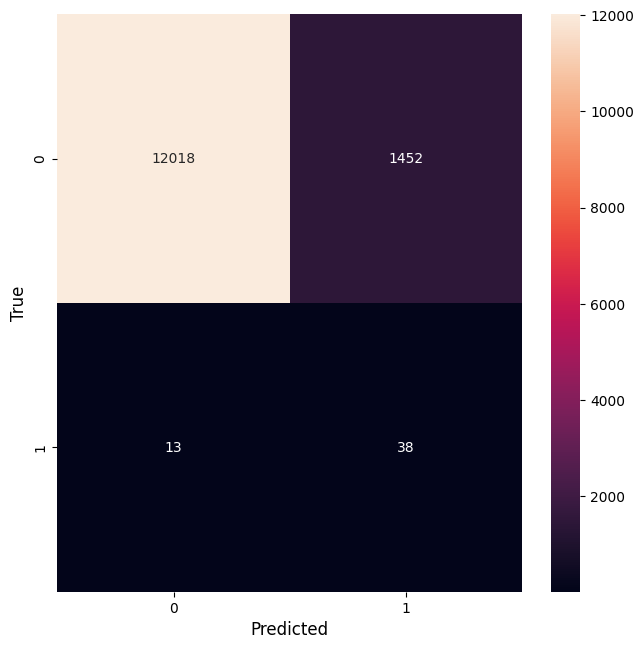

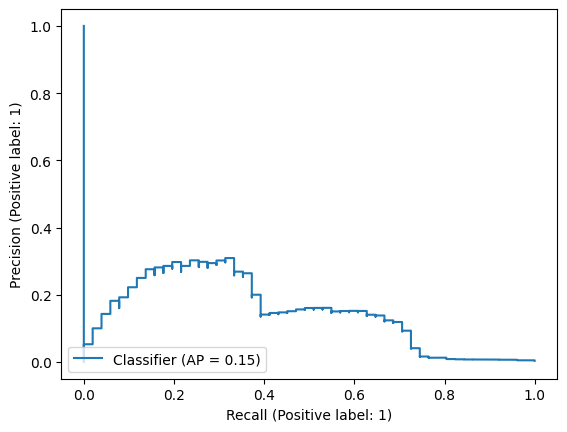

In [16]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y)